# Running base model and filter

Jupyter notebook to run basic analysis for the paper
> Oswald, Malleson and Suchak (2023) An agent-based model of the 2020 international policy diffusion in response to the COVID-19 pandemic with particle filter.

Reproducing figures:
* Figure 2 is reproduced 
* IN ORDER TO REPRODUCE FIGURE 4 RUN THIS SCRIPT WITH no_of_iterations = 100
* IN ORDER TO REPRODUCE FIGURE 5 RUN THIS SCRIPT WITH no_of_iterations = 1000

In [1]:
# Loading packages

In [2]:
import os
##### IMPORTANT ######
#### CHANGE YOUR WORKING DIRECTORY Explicitly YOURSELF to "mypath/covpol" 
#### (whereever you keep covpol)
#### e.g.os.chdir("folder1/folder2/covpol")
#os.chdir("./covpol") THIS works only if Jupyter knows your working from a specific folder
os.chdir("C:/Users/earyo/Dropbox/Arbeit/postdoc_leeds/ABM_python_first_steps/implement_own_covid_policy_model/covpol")

Import local code:

In [3]:
### import model class (which itself imports agent class)
from model_class import CountryModel
from particle_filter_class import ParticleFilter
from run_base_model_opt import model_run    

Import packages:

In [4]:
import mesa
import mesa.time
import mesa.space
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math as math
import pandas as pd
import copy as copy
from math import radians, cos, sin, asin, sqrt
import random
from datetime import datetime as dt

# import random 
from random import sample
### colormaps import
import matplotlib.cm
##
from multiprocessing import Pool
##
import pytest

from multiprocessing import Pool

## Load data

In [5]:
#os.chdir("C:/Users/earyo/Dropbox/Arbeit/postdoc_leeds/ABM_python_first_steps/implement_own_covid_policy_model")

with open('../data/correlation_between_policies_and_metrics.csv') as f:
    data = pd.read_csv(f, encoding = 'unicode_escape')

In [6]:
### read country/agent data
with open('../data/agent_data_v2.csv') as f:
    agent_data = pd.read_csv(f, encoding = 'unicode_escape')


Num_agents = len(agent_data)
agent_data["gdp_pc"] = pd.to_numeric(agent_data["gdp_pc"])

In [7]:
##### Read data for calibration
#### aggregate diffusion curve data

with open('../data/lockdown_diffusion_curve_updated_for_calibration.csv') as f:
    lockdown_data1 = pd.read_csv(f, encoding = 'unicode_escape', header = None)

In [8]:
#### data per country
with open('../data/lockdown_tracking.csv') as f:
    lockdown_data2  = pd.read_csv(f, encoding = 'unicode_escape')

## Producing figures

Plot Figure 2 

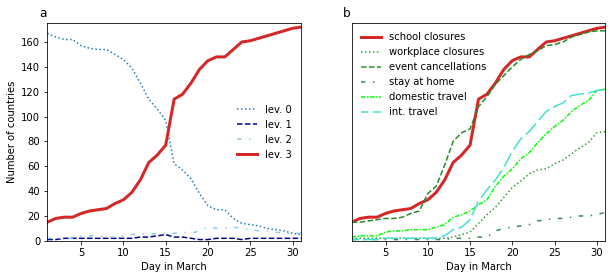

In [9]:
fig1, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))

ax1.plot(np.linspace(1,31,31), data["level_0"], label = "lev. 0", c = "tab:blue", linestyle = "dotted")
ax1.plot(np.linspace(1,31,31), data["level_1"], label = "lev. 1", c = "darkblue", linestyle = "dashed")
ax1.plot(np.linspace(1,31,31), data["level_2"], label = "lev. 2", c = "skyblue", linestyle = (0, (3, 5, 1, 5)))
ax1.plot(np.linspace(1,31,31), data["level_3"], label = "lev. 3", c = "tab:red", linewidth = 3)
ax1.set_xlabel("Day in March")
ax1.set_ylabel("Number of countries")
ax1.set_ylim((0,175))
ax1.legend(frameon = False)
ax1.margins(0)
ax1.text(0, 180, 'a', fontsize=12)

ax2.plot(np.linspace(1,31,31), data["school_closures"], label = "school closures", c = "tab:red", linewidth = 3)
ax2.plot(np.linspace(1,31,31), data["work_place_closures"], label = "workplace closures", c = "tab:green", linestyle = "dotted")
ax2.plot(np.linspace(1,31,31), data["public_event_cancellations"], label = "event cancellations", c = "forestgreen", linestyle = "dashed")
ax2.plot(np.linspace(1,31,31), data["stay_at_home"], label = "stay at home", c = "seagreen", linestyle = (0, (3, 5, 1, 5)))
ax2.plot(np.linspace(1,31,31), data["restrictions_internal_movements"], label = "domestic travel", c = "lime", linestyle = (0, (3, 1, 1, 1)))
ax2.plot(np.linspace(1,31,31), data["international_travel_controls"], label = "int. travel", c = "turquoise", linestyle = (5, (10, 3)))
ax2.set_xlabel("Day in March")
ax2.set_ylim((0,175))
ax2.get_yaxis().set_visible(False)
ax2.legend(frameon = False)
ax2.margins(0)
ax2.text(0, 180, 'b', fontsize=12)

plt.savefig('data_properties.png', bbox_inches='tight', dpi=300)

In [10]:
start = dt.now()
#os.chdir("C:/Users/earyo/Dropbox/Arbeit/postdoc_leeds/ABM_python_first_steps/implement_own_covid_policy_model/covpol")
no_of_iterations = 100
for j in range(no_of_iterations):
        ### call the model iteration
        ##4th parameter initial conditions can be real, no countries yet or random
        model = CountryModel(0.01, 0.13, 18, 'real', 'no')
        for i in range(31):
            model.step()

            df1 = model.datacollector.get_agent_vars_dataframe()
            df2 = model.datacollector.get_model_vars_dataframe()
        
        ### here insert code for merging dataframes
        df3 = (df1.reset_index(level=0)).reset_index(level = 0)
        df4 = pd.DataFrame(np.repeat(df2.values, 200, axis=0))
        df4.columns = df2.columns
        df4 = pd.concat([df4, df3], axis=1, join='inner')
        df4 = df4[["code","AgentID", "Step", "minimum_difference", "Lockdown", "income",
                   "politicalregime", "social_thre", "own_thre",
                   "adoption_mode"]]
        df4.insert(0, "iteration", [j]*len(df4))
        
        if j == 0 :
            df_results = pd.DataFrame(columns = df4.columns)
            df_results = pd.concat([df_results, df4], join="inner")
        else:
            df_results = pd.concat([df_results, df4], join="inner", ignore_index=True)
        
        print("model iteration is " + str(j))
        
        #CountryAgent.reset(CountryAgent)

running_secs = (dt.now() - start).seconds
print("running time was " + str(running_secs) + " sec")


model iteration is 0
model iteration is 1
model iteration is 2
model iteration is 3
model iteration is 4
model iteration is 5
model iteration is 6
model iteration is 7
model iteration is 8
model iteration is 9
model iteration is 10
model iteration is 11
model iteration is 12
model iteration is 13
model iteration is 14
model iteration is 15
model iteration is 16
model iteration is 17
model iteration is 18
model iteration is 19
model iteration is 20
model iteration is 21
model iteration is 22
model iteration is 23
model iteration is 24
model iteration is 25
model iteration is 26
model iteration is 27
model iteration is 28
model iteration is 29
model iteration is 30
model iteration is 31
model iteration is 32
model iteration is 33
model iteration is 34
model iteration is 35
model iteration is 36
model iteration is 37
model iteration is 38
model iteration is 39
model iteration is 40
model iteration is 41
model iteration is 42
model iteration is 43
model iteration is 44
model iteration is 4

Plot 1 number of lockdowns over time steps.

Plotting takes too long if too many runs.

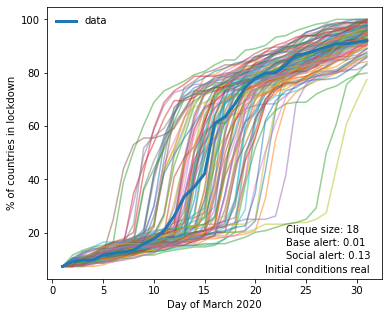

In [11]:
if no_of_iterations <= 200:

    fig1, ax1 = plt.subplots(figsize = (6,5))
    
    for i in range(no_of_iterations):
        ax1.plot( df_results[(df_results.iteration == i) & (df_results.AgentID == 0)]["Step"] + 1,
                  np.sum(np.split(np.array(df_results[(df_results.iteration == i)]["Lockdown"]),31),axis=1) / Num_agents * 100, alpha = 0.5)
    ax1.plot(df_results[(df_results.iteration == i) & (df_results.AgentID == 0)]["Step"] + 1, 
             lockdown_data1[0]*100,
             linewidth=3 ,label = "data")
    ax1.set_xlabel("Day of March 2020")
    ax1.set_ylabel("% of countries in lockdown")
    ax1.legend(frameon=False)
    ax1.text(23, 20, "Clique size: " + str(model.clique_size))
    ax1.text(23, 15, "Base alert: " + str(model.base_alert))
    ax1.text(23, 10, "Social alert: " + str(model.social_base_threshold))
    ax1.text(21, 5, "Initial conditions " + str(model.initial_conditions))
    #plt.show()


Plot 1.1 distribution of runs at every time step is the distribution of the model estimate normal or not?

`df_results_filtered`

In [12]:
df_results_filtered = df_results[(df_results.AgentID == 9)]

array_run_results = np.zeros((no_of_iterations,31))
for i in range(no_of_iterations):
    array_run_results[i,:] = np.sum(np.split(np.array(df_results[(df_results.iteration == i)]["Lockdown"]),31),axis=1)
    print("array run results making is at ", i)


###plotting takes too long if too many runs and also does not make sense if too few
if no_of_iterations >= 10 and no_of_iterations <= 50:
    
    fig = plt.figure(figsize=(12, 12), constrained_layout=True)
    spec = fig.add_gridspec(ncols=6, nrows=6)
    
    for i in range(31):
        globals()['ax11%s' % i]  = fig.add_subplot(spec[math.floor(i/6), i%6])
        globals()['ax11%s' % i].hist(array_run_results[:,i], bins = int(no_of_iterations/10))
        globals()['ax11%s' % i].set_xlim([0, 164])
        #globals()['ax11%s' % i].set_ylim([0, no_of_iterations])
    fig.suptitle('Distribution of run results at every time step')
    #https://stackoverflow.com/questions/6986986/bin-size-in-matplotlib-histogram
    plt.savefig('Distribution of runs over each time step.png', bbox_inches='tight', dpi=300)


array run results making is at  0
array run results making is at  1
array run results making is at  2
array run results making is at  3
array run results making is at  4
array run results making is at  5
array run results making is at  6
array run results making is at  7
array run results making is at  8
array run results making is at  9
array run results making is at  10
array run results making is at  11
array run results making is at  12
array run results making is at  13
array run results making is at  14
array run results making is at  15
array run results making is at  16
array run results making is at  17
array run results making is at  18
array run results making is at  19
array run results making is at  20
array run results making is at  21
array run results making is at  22
array run results making is at  23
array run results making is at  24
array run results making is at  25
array run results making is at  26
array run results making is at  27
array run results making is at

Plot 2 average minimum_difference (should decay over time) because more countries adopt a lockdown so for each country more and more similar countries serve as a benchmark.

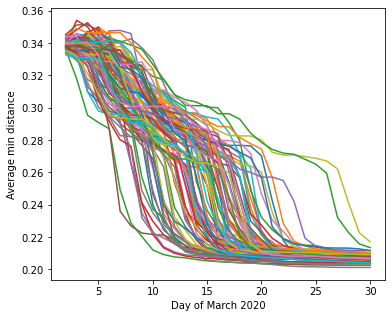

In [13]:
if no_of_iterations <= 200:

    fig2, ax2 = plt.subplots(figsize = (6,5))
    
    for i in range(no_of_iterations):
        df_iter = df_results[(df_results.iteration == i)]
        average_min_diff_array = np.zeros((31,1))
        average_min_and_max_diff = np.zeros((31,2))
        for j in range(31):
               average_min_diff_array[j,0] = np.mean( df_iter[(df_iter.Step == j)]["minimum_difference"])
               average_min_and_max_diff[j,0] = min(df_iter[(df_iter.Step == j)]["minimum_difference"])
               average_min_and_max_diff[j,1] = max(df_iter[(df_iter.Step == j)]["minimum_difference"])
                             
        ax2.plot((df_results[(df_results.iteration == i) & (df_results.AgentID == 0)]["Step"] + 1)[1:30], average_min_diff_array[1:30])
        #plt.plot((df_results[(df_results.iteration == i) & (df_results.AgentID == 0)]["Step"] + 1)[1:30], average_min_and_max_diff[1:30,0])
        #plt.plot((df_results[(df_results.iteration == i) & (df_results.AgentID == 0)]["Step"] + 1)[1:30], average_min_and_max_diff[1:30,1])
           
    ax2.set_xlabel("Day of March 2020")
    ax2.set_ylabel("Average min distance")
    #plt.show()

Plot 3 plots the micro-validity (or non-validity of the model) by measuring the difference between the day a country adopts in the model and adopted in the real-world (thus the difference is measured in number of days).

If number is positive it is too late, if negative, it is too early predicted.

In [14]:
micro_validity_BIG = np.zeros((no_of_iterations,164))
if no_of_iterations <= 50:
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    for i in range(Num_agents):  
            model_lockdown_data = df_results[(df_results.code == agent_data["code"][i]) & (df_results.Lockdown == 1)]
            real_world_lockdown_date = lockdown_data2[(lockdown_data2.Code ==  agent_data["code"][i]) & (lockdown_data2.lockdown == 1)]
            for p in range(no_of_iterations):
                model_lockdown_data2 = model_lockdown_data[(model_lockdown_data.iteration == p)]["Step"]
                if len(model_lockdown_data2) > 0 and len(real_world_lockdown_date) > 0:
                    difference = model_lockdown_data2.iloc[0] - (int(real_world_lockdown_date.iloc[0]["Day"][0:2])-1)
                    micro_validity_BIG[p,i] = difference 
                    ax3.scatter(i,difference, color = "tab:blue", alpha = 0.2)
            print("iteration of micro-level-plot is " + str(i))
    ax3.set_ylabel("diff. in days")   
    ax3.set_xlabel("country index")  
    ax3.plot([0,164],[0,0], color = "black", linewidth = 3)
    ax3.margins(0)
    plt.savefig('Micro_validity_1.png', bbox_inches='tight', dpi=300)
    #plt.show()


Plot 3 NEW BETTER VERSION

In [15]:
df_differences_per_country = pd.DataFrame(data=micro_validity_BIG.T,
                 index=agent_data.code , 
                 columns=np.linspace(0,no_of_iterations-1,no_of_iterations).astype(int),
                 dtype=None, copy=None)

micro_validity_BIG_sq_diff_sum = np.sum((micro_validity_BIG - 0)**2, axis = 0)
df_differences_per_country = pd.concat([df_differences_per_country,
                                        pd.DataFrame(micro_validity_BIG_sq_diff_sum, 
                                                     index = agent_data.code, columns = ["error"])],
                                       axis = 1 )

df_differences_per_country =  pd.concat([df_differences_per_country,
                                         pd.DataFrame(np.array(agent_data["gdp_pc"]), index = agent_data.code),
                                         pd.DataFrame(np.array(agent_data["democracy_index"]), index = agent_data.code)], axis = 1)

df_differences_per_country_sorted = df_differences_per_country.sort_values(by=['error'])

## https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib 
## colormap legend

cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=10)
if no_of_iterations < 50:
    fig30, ax30 = plt.subplots(figsize=(12, 6))
    for i in range(164):
        ax30.scatter(np.repeat(i, len(df_differences_per_country_sorted.iloc[i,0:no_of_iterations])),
                     df_differences_per_country_sorted.iloc[i,0:no_of_iterations], 
                     color = cmap(df_differences_per_country_sorted.iloc[i,12]/10), alpha = 0.2)    
        ax30.set_ylabel("diff. in days", size = 16)   
        ax30.set_xlabel("country index", size = 16) 
        ax30.plot([0,164],[0,0], color = "black", linewidth = 3)
        ax30.margins(x=0)
    #ax30.set_xticks(np.linspace(1,164,164), df_differences_per_country_sorted.index, rotation=90, size = 8)
    ax30.xaxis.set_tick_params(labelsize=16)
    ax30.yaxis.set_tick_params(labelsize=16)
    
    cbar_ax = fig30.add_axes([0.35, 0.21, 0.15, 0.03])
    #fig30.colorbar(ax30, cax=cbar_ax)
    fig30.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cbar_ax, orientation='horizontal', label='Democracy index')
    
    plt.savefig('Micro_validity_2.png', bbox_inches='tight', dpi=300)


Plot 4 fan chart of model runs. This function makes use of resources from stackoverflow [[1](https://stackoverflow.com/questions/28807169/making-a-python-fan-chart-fan-plot)][[2](https://stackoverflow.com/questions/66146705/creating-a-fanchart-from-a-series-of-monte-carlo-projections-in-python)].

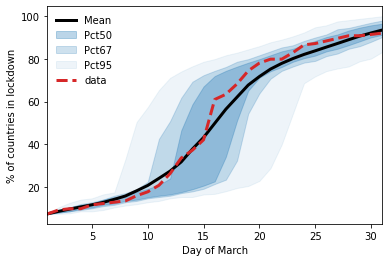

In [16]:
def create_fanchart(arr):
    x = np.arange(arr.shape[0]) + 1
    # for the median use `np.median` and change the legend below
    mean = np.mean(arr, axis=1)
    offsets = (25,67/2,47.5)
    fig, ax = plt.subplots()
    ax.plot(x, mean, color='black', lw=3)
    for offset in offsets:
        low = np.percentile(arr, 50-offset, axis=1)
        high = np.percentile(arr, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (55 - offset) / 100
        ax.fill_between(x, low, high, color='tab:blue', alpha=alpha)
    
    ax.plot(df_results[(df_results.iteration == 0) & (df_results.AgentID == 0)]["Step"] +1, 
             lockdown_data1[0]*100,
             linewidth=3 ,label = "data", linestyle= "--", color = "tab:red")
    
    ax.set_xlabel("Day of March")
    ax.set_ylabel("% of countries in lockdown")
    ax.legend(['Mean'] + [f'Pct{int(2*o)}' for o in offsets] + ['data'], frameon = False)
    ax.margins(x=0)
    return fig, ax

create_fanchart(array_run_results.T/Num_agents*100)
plt.savefig('fanchart_1_macro_validity.png', bbox_inches='tight', dpi=300)

4.1 report least squares of mean to data and variance per time step (both metrics need to minimized)

In [17]:
mean_model_runs = np.mean(array_run_results, axis = 0)
variance_model_runs = np.var(array_run_results, axis = 0)
std_model_run = np.std(array_run_results, axis = 0)
std_model_run_percentage = np.std(array_run_results/164, axis = 0)


Plot 5 micro validity over time as a function of how many countries are in their correct lockdown state (lockdown yes or no).

Test whether dataframes are in the exact same order
```
test = df_results[(df_results.iteration == i) & (df_results.Step == j)]["code"] == pd.Series.reset_index(lockdown_data2[(lockdown_data2.model_step == j)]["Code"], drop=True)
```

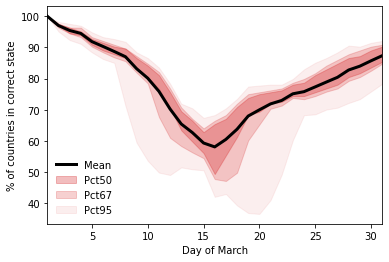

In [18]:
micro_validity_metric_array = np.zeros((31,no_of_iterations))
   
for i in range(no_of_iterations):
    
  alpha = pd.Series.reset_index(df_results[(df_results.iteration == i) ]["Lockdown"], drop = True) 
  beta =  pd.Series.reset_index(lockdown_data2.sort_values(['model_step', 'Entity'])["lockdown"],drop = True)          
  micro_validity_metric_array[:,i] = np.mean(np.array_split(np.array(alpha == beta),31),axis = 1)


mean_at_t_15 = mean_model_runs[15]/164
datapoints_at_t_15 = array_run_results[:,15]/164

def create_fanchart_2(arr):
    x = np.arange(arr.shape[0])+1
    # for the median use `np.median` and change the legend below
    mean = np.mean(arr, axis=1)
    offsets = (25,67/2,47.5)
    fig, ax = plt.subplots()
    ax.plot(x, mean, color='black', lw=3)
    for offset in offsets:
        low = np.percentile(arr, 50-offset, axis=1)
        high = np.percentile(arr, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (55 - offset) / 100
        ax.fill_between(x, low, high, color='tab:red', alpha=alpha)
        ax.set_xlabel("Day of March")
        ax.set_ylabel("% of countries in correct state")
        ax.legend(['Mean'] + [f'Pct{int(2*o)}' for o in offsets] + ['data'], frameon = False)
    ax.margins(x=0)
    return fig, ax


create_fanchart_2(micro_validity_metric_array*100)
plt.savefig('fanchart_2_micro_validity.png', bbox_inches='tight', dpi=300)
#plt.show()

Joint figure fan charts

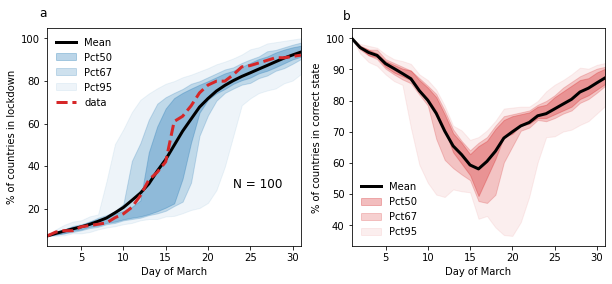

In [19]:
fig1, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))

arr = array_run_results.T/Num_agents*100
x = np.arange(arr.shape[0]) + 1
# for the median use `np.median` and change the legend below
mean = np.mean(arr, axis=1)
original_mean = copy.deepcopy(mean)
CI_original_lines = np.zeros((6,len(arr)))
offsets = (25,67/2,47.5)
ax1.plot(x, mean, color='black', lw=3)
for idx, offset in enumerate(offsets):
   low = np.percentile(arr, 50-offset, axis=1)
   high = np.percentile(arr, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
   alpha = (55 - offset) / 100
   ax1.fill_between(x, low, high, color='tab:blue', alpha=alpha)
   CI_original_lines[2*idx,:]= copy.deepcopy(high) 
   CI_original_lines[2*idx + 1,:]= copy.deepcopy(low) 
    
ax1.plot(df_results[(df_results.iteration == 0) & (df_results.AgentID == 0)]["Step"] +1, 
             lockdown_data1[0]*100,
             linewidth=3 ,label = "data", linestyle= "--", color = "tab:red")
    
ax1.set_xlabel("Day of March")
ax1.set_ylabel("% of countries in lockdown")
ax1.legend(['Mean'] + [f'Pct{int(2*o)}' for o in offsets] + ['data'], frameon = False)
ax1.margins(x=0)
ax1.text(0, 110, 'a', fontsize=12)
ax1.text(23, 30, f'N = {no_of_iterations}', fontsize=12)


arr2 = micro_validity_metric_array*100
x = np.arange(arr.shape[0])+1
    # for the median use `np.median` and change the legend below
mean = np.mean(arr2, axis=1)
offsets = (25,67/2,47.5)
ax2.plot(x, mean, color='black', lw=3)
for offset in offsets:
        low = np.percentile(arr2, 50-offset, axis=1)
        high = np.percentile(arr2, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (55 - offset) / 100
        ax2.fill_between(x, low, high, color='tab:red', alpha=alpha)
ax2.set_xlabel("Day of March")
ax2.set_ylabel("% of countries in correct state")
ax2.legend(['Mean'] + [f'Pct{int(2*o)}' for o in offsets] + ['data'], frameon = False)
ax2.margins(x=0)
ax2.text(0, 106, 'b', fontsize=12)

plt.savefig('fig4.png', bbox_inches='tight', dpi=300)

In [20]:
pf_parameters = {
  "da_window": 5,
  "da_instances": 30/5,
  "No_of_particles": no_of_iterations
}


model_parameters = {
  "base_alert": 0.01,
  "social_base_threshold": 0.13,
  "clique_size": 18,
  "initial_conditions": 'real',
  "data_update": 'no'
}

current_PF = ParticleFilter(CountryModel, model_parameters, pf_parameters)  
current_PF.run_particle_filter()    

[CountryModel('Model_id 0'), CountryModel('Model_id 1'), CountryModel('Model_id 2'), CountryModel('Model_id 3'), CountryModel('Model_id 4'), CountryModel('Model_id 5'), CountryModel('Model_id 6'), CountryModel('Model_id 7'), CountryModel('Model_id 8'), CountryModel('Model_id 9'), CountryModel('Model_id 10'), CountryModel('Model_id 11'), CountryModel('Model_id 12'), CountryModel('Model_id 13'), CountryModel('Model_id 14'), CountryModel('Model_id 15'), CountryModel('Model_id 16'), CountryModel('Model_id 17'), CountryModel('Model_id 18'), CountryModel('Model_id 19'), CountryModel('Model_id 20'), CountryModel('Model_id 21'), CountryModel('Model_id 22'), CountryModel('Model_id 23'), CountryModel('Model_id 24'), CountryModel('Model_id 25'), CountryModel('Model_id 26'), CountryModel('Model_id 27'), CountryModel('Model_id 28'), CountryModel('Model_id 29'), CountryModel('Model_id 30'), CountryModel('Model_id 31'), CountryModel('Model_id 32'), CountryModel('Model_id 33'), CountryModel('Model_id 

PLOTTING PARTICLE FILTER RESULTS 

In [ ]:
### TO DO verify whether pf works correctly 
No_of_particles = pf_parameters['No_of_particles']
da_window = pf_parameters['No_of_particles']
results_pf = np.zeros((31, No_of_particles))
micro_validity_metric_array_pf = np.zeros((31, No_of_particles))

Dit={}
time_steps = 31
for i in range(31):
    for j in range(No_of_particles):
        ### key is a tuple where i equals time step, j particle number and
        ### the third number the model id, initially unique, but later can
        ### be associated with several particles because they are resampled 
        ### versions of one another. Therefore ultimately j is the *unique* 
        ### identifier as well as the tuple as a whole given j. 
        key = (i,j, current_PF.part_filtered_all[i][j].model_id)
        value = current_PF.part_filtered_all[i][j].datacollector.get_agent_vars_dataframe()
        Dit[key] = value
        df = Dit[key]
        df = (df.reset_index(level=0)).reset_index(level = 0)
        results_pf[i,j] = df[(df.Step == i)]["Lockdown"].sum()
        micro_state = pd.Series.reset_index(df[(df.Step == i)]["Lockdown"],drop = True)
        micro_state_data = pd.Series.reset_index(lockdown_data2[(lockdown_data2.model_step == i)]["lockdown"],drop = True) 
        micro_validity_metric_array_pf[i,j] = np.mean(micro_state == micro_state_data)
        #print(i,j)


def create_fanchart_PF(arr):
    x = np.arange(arr.shape[0]) + 1
    # for the median use `np.median` and change the legend below
    mean = np.mean(arr, axis=1)
    offsets = (25,67/2,47.5)
    fig, ax = plt.subplots()
    ax.plot(x, mean, color='black', lw=3)
    for offset in offsets:
        low = np.percentile(arr, 50-offset, axis=1)
        high = np.percentile(arr, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (55 - offset) / 100
        ax.fill_between(x, low, high, color='tab:blue', alpha=alpha)

    ax.plot(df_results[(df_results.iteration == 0) & (df_results.AgentID == 0)]["Step"] +1, 
             lockdown_data1[0]*100,
             linewidth=3 ,label = "data", linestyle= "--", color = "tab:red")

    ax.set_xlabel("Day of March")
    ax.set_ylabel("% of countries in lockdown")
    ax.legend(['Mean'] + [f'Pct{int(2*o)}' for o in offsets] + ['data'], frameon = False)
    ax.margins(x=0)
    return fig, ax

create_fanchart_PF(results_pf/Num_agents*100)
plt.savefig('fanchart_1_macro_validity_PF.png', bbox_inches='tight', dpi=300)
plt.show()


##### PLOT mean squared error per time step. pf results vs no pf results 
results_pf_percent = results_pf/164
square_diffs_pf = np.zeros((31,No_of_particles))
for i in range(No_of_particles):
    square_diffs_pf[:,i] = (results_pf_percent[:,i] - lockdown_data1.iloc[:,0].to_numpy())**2

mse_pf =  np.mean(square_diffs_pf, axis = 1)


results_pf_percent = results_pf/164
results_percent = array_run_results.T/164
square_diffs_pf = np.zeros((31,No_of_particles))
square_diffs = np.zeros((31,No_of_particles))
for i in range(No_of_particles):
    square_diffs_pf[:,i] = (results_pf_percent[:,i] - lockdown_data1.iloc[:,0].to_numpy())**2
    square_diffs[:,i] = (results_percent[:,i] - lockdown_data1.iloc[:,0].to_numpy())**2 

mse_pf =  np.mean(square_diffs_pf, axis = 1)
mse =  np.mean(square_diffs, axis = 1)


plt.plot(np.linspace(1,31,31), mse)
plt.plot(np.linspace(1,31,31), mse_pf)
plt.xlabel("Day of March")
plt.ylabel("Mean squared error") ### perhaps plot squared error as fan-chart around?
plt.savefig('MSE_over_time.png', bbox_inches='tight', dpi=300)
plt.show()


mse_list = [sum(mse), sum(mse_pf)]
df_mse = pd.DataFrame(mse_list)

df_mse.to_csv("df_mse.csv", sep=',')


PLOTTING new microvalidity fanchart

In [ ]:
def create_fanchart_2_PF(arr):
    x = np.arange(arr.shape[0])+1
    # for the median use `np.median` and change the legend below
    mean = np.mean(arr, axis=1)
    offsets = (25,67/2,47.5)
    fig, ax = plt.subplots()
    ax.plot(x, mean, color='black', lw=3)
    for offset in offsets:
        low = np.percentile(arr, 50-offset, axis=1)
        high = np.percentile(arr, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (55 - offset) / 100
        ax.fill_between(x, low, high, color='tab:red', alpha=alpha)
        ax.set_xlabel("Day of March")
        ax.set_ylabel("% of countries in correct state")
        ax.legend(['Mean'] + [f'Pct{int(2*o)}' for o in offsets] + ['data'], frameon = False)
    ax.margins(x=0)
    return fig, ax


create_fanchart_2_PF(micro_validity_metric_array_pf*100)
plt.savefig('fanchart_2_micro_validity_pf.png', bbox_inches='tight', dpi=300)
plt.show()

Joint Figure 5 fan charts

In [ ]:
fig2, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))

arr = results_pf/Num_agents*100
x = np.arange(arr.shape[0]) + 1
# for the median use `np.median` and change the legend below
mean = np.mean(arr, axis=1)
offsets = (25,67/2,47.5)
ax1.plot(x, mean, color='black', lw=3)
ax1.plot(x, original_mean, color='m', linestyle = 'dotted', lw=3)
for offset in offsets:
   low = np.percentile(arr, 50-offset, axis=1)
   high = np.percentile(arr, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
   alpha = (55 - offset) / 100
   ax1.fill_between(x, low, high, color='tab:blue', alpha=alpha)


ax1.plot(df_results[(df_results.iteration == 0) & (df_results.AgentID == 0)]["Step"] +1, 
             lockdown_data1[0]*100,
             linewidth=3 ,label = "data", linestyle= "--", color = "tab:red")
ax1.plot(x, CI_original_lines[4, :], c = 'grey', alpha = 0.5, linestyle = 'dotted')
ax1.plot(x, CI_original_lines[5, :], c = 'grey', alpha = 0.5, linestyle = 'dotted')


ax1.set_xlabel("Day of March")
ax1.set_ylabel("% of countries in lockdown")
ax1.legend(['Mean'] + ['Ensemble only mean'] + [f'Pct{int(2*o)}' for o in offsets] + ['data'] + ['Pct95e'], frameon = False, loc = 'upper left')
ax1.margins(x=0)
ax1.text(0, 110, 'a', fontsize=12)
ax1.text(23, 30, f'N = {no_of_iterations}', fontsize=12)


#for idx, y in enumerate(CI_original_lines):
 #   ax1.plot(x, CI_original_lines[idx, :], c = 'grey', alpha = 0.5)


ax2.plot(np.linspace(1,31,31), mse, label = "MSE base")
ax2.plot(np.linspace(1,31,31), mse_pf, label = "MSE PF", linestyle = 'dashed')
ax2.set_xlabel("Day of March")
ax2.set_ylabel("Mean squared error") ### perhaps plot squared error as fan-chart around?
ylimit = ax2.get_ylim()
ax2.text(0, ylimit[1]*1.09, 'b', fontsize=12)
ax2.legend(frameon = False, loc = 'lower center', fontsize = 9)
ax2.margins(0)
ax2.set_ylim(0 ,0.06)


plt.savefig('fig5.png', bbox_inches='tight', dpi=300)

microvalidity pf vs. no pf as a chart of the mean lines

In [ ]:
fig3, ax1 = plt.subplots(figsize = (5.5,5))
arr1 = micro_validity_metric_array*100
arr2 = micro_validity_metric_array_pf*100
x = np.arange(arr1.shape[0])+1
y = np.arange(arr2.shape[0])+1
# for the median use `np.median` and change the legend below
mean1 = np.mean(arr1, axis=1)
mean2 = np.mean(arr2, axis=1)
offsets = (25,67/2,47.5)
ax1.plot(x, mean1, color='black', lw=3, label = "no_pf")
ax1.plot(y, mean2, color='tab:red', lw=3, label = "with_pf")
ax1.set_xlabel("Day of March")
ax1.set_ylabel("% in correct state")
ax1.legend()